## Bank Customer Churn Prediction: A Strategic Approach to Retention

### Executive Summary
**Goal:** To reduce customer attrition by building a machine learning model that segments customers based on their probability of churning. These probability scores will power proactive retention strategies, such as targeted email campaigns and personalized promotional offers.

**Key Strategy:**
Since **Customer Acquisition Cost (CAC)** is significantly higher than retention costs, this project prioritizes **Recall** as the primary performance metric. We aim to identify as many at-risk customers as possible, accepting a higher rate of False Positives (offering discounts to safe customers) to avoid False Negatives (losing a customer unnoticed).

**Project Overview:**
* **Data Source:** Banking dataset provided by **Maven Analytics**.
* **Methodology:** Data cleaning, feature engineering, and comparative modeling using **Logistic Regression** and **Random Forest**.
* **Interpretability:** Utilization of **SHAP Values** to explain individual predictions and understand the key drivers of churn.

**Key Results:**
* **Model Performance:** We improved the detection of at-risk customers (**Recall**) to **76%** using a tuned Random Forest Classifier.
* **Business Value:** This allows the bank to proactively target ~3 out of 4 potential churners, significantly reducing revenue loss.

**Top 3 Drivers of Churn (Insights):**
Based on our analysis, the highest risk segments are:
1.  **Demographics:** Older customers (45+) are the most likely to leave.
2.  **Geography:** German customers show a disproportionately high churn rate compared to France/Spain.
3.  **Product Strategy:** Customers with 3+ products are highly unstable, suggesting issues with product complexity or "over-bundling."

## Table of Contents
1. [Problem Statement & Business Context](#problem-statement)
2. [Data Overview](#dataset-overview)
3. [Environment Setup & Data Ingestion](#environment-setup)
4. [Data Preprocessing & Cleaning](#data-cleaning)
4. [Exploratory Data Analysis](#eda)
5. [Feature Engineering](#feature-engineering)
6. [Model Training: Logistic Regression](#logistic-regression)
7. [Final Model: Random Forest](#random-forest)
8. [Model Explainability (SHAP)](#shap-analysis)
9. [Deployment Simulation](#deployment)
10. [Conclusion & Recommendations](#conclusion)

## 1. Problem Statement & Business Context <a id="problem-statement"></a>

In the banking industry, **churn** is a critical metric. Industry studies suggest that acquiring a new customer can cost **5x more** than retaining an existing one. Therefore, the ability to predict which customers are about to leave is a significant competitive advantage.

### The Business Case
We are addressing a binary classification problem:
* **Class 0 (Retained):** The customer stays with the bank.
* **Class 1 (Churned):** The customer closes their account.

### The "Recall-First" Strategy
For this specific business case, the cost of errors is asymmetric:
* **False Negative (High Cost):** We predict a customer will stay, but they leave. **Result:** We lose the customer and their lifetime value.
* **False Positive (Low Cost):** We predict a customer will leave, but they were happy. **Result:** We send them a retention offer (e.g., a lower interest rate or bonus). This slightly reduces margin but likely increases loyalty.

**Conclusion:** We will optimize our models to maximize **Recall** to capture the highest percentage of potential churners, ensuring our retention team has the opportunity to intervene.

## 2. Dataset Overview <a id="dataset-overview"></a>

The dataset, sourced from **Maven Analytics**, contains **10,000 records** representing individual bank customers. The data provides a holistic view of the customer's relationship with the bank, ranging from demographic details to detailed financial metrics.

### 2.1 Feature Dictionary
To facilitate analysis, we have categorized the features into three logical groups:

**A. Customer Demographics**
* `CustomerId`: Unique identifier for each customer (to be removed from modeling).
* `Surname`: Customer's last name (to be removed to maintain privacy/generalization).
* `Geography`: The country where the customer resides (e.g., France, Spain, Germany).
* `Gender`: Biological sex of the customer.
* `Age`: Age of the customer in years.

**B. Financial Relationship**
* `CreditScore`: A numerical value representing the customer's creditworthiness.
* `Balance`: The current account balance. 
* `EstimatedSalary`: The customer's estimated annual salary. 
* `NumOfProducts`: The number of banking products the customer uses (e.g., savings, credit, loans).
* `HasCrCard`: Binary flag (1 = Yes, 0 = No) indicating if the customer holds a credit card.

**C. Engagement & Loyalty**
* `Tenure`: The number of years the customer has been with the bank.
* `IsActiveMember`: Binary flag indicating if the customer is considered an active user.

### 2.3 Target Variable
* `Exited`: The binary target variable for our classification model.
    * **0 (Retained):** Customer is still with the bank.
    * **1 (Churned):** Customer has closed their account.

## 3. Environment Setup & Data Ingestion <a id="environment-setup"></a>

### 3.1 Technical Stack
To build a robust and interpretable churn prediction model, we leverage the following Python ecosystem:
* **Data Manipulation:** `Pandas` & `NumPy` for efficient data processing.
* **Visualization:** `Matplotlib` & `Seaborn` for exploratory data analysis (EDA).
* **Machine Learning:** `Scikit-Learn` for preprocessing, model selection, and classification algorithms.
* **Explainability:** `SHAP` (SHapley Additive exPlanations) to interpret model decisions and feature importance.

### 3.2 Data Acquisition & Integration
The raw data simulates a relational database structure, provided in a multi-sheet Excel workbook (`Bank_Churn_Messy.xlsx`).
* **Source A (Customer Info):** Contains demographic details (Age, Gender, Geography).
* **Source B (Account Info):** Contains financial metrics (Balance, Tenure, Product holdings).

**Integration Strategy:**
We ingest these sheets separately and perform a **Left Join** on the unique primary key (`CustomerId`). This consolidates the data into a single analytical view (`bank_data_full`) while ensuring all customer demographic records are retained.

In [2]:
#pip install shap

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import KNNImputer
import shap
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [4]:
customer_info = pd.read_excel('Bank_Churn_Messy.xlsx', sheet_name = 0)
account_info = pd.read_excel('Bank_Churn_Messy.xlsx', sheet_name = 1)
bank_data_full = pd.merge(customer_info,account_info,how ='left',on='CustomerId')
bank_data_full.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure_x,EstimatedSalary,Balance,NumOfProducts,HasCrCard,Tenure_y,IsActiveMember,Exited
0,15634602,Hargrave,619,FRA,Female,42.0,2,€101348.88,€0.0,1,Yes,2,Yes,1
1,15634602,Hargrave,619,FRA,Female,42.0,2,€101348.88,€0.0,1,Yes,2,Yes,1
2,15647311,Hill,608,Spain,Female,41.0,1,€112542.58,€83807.86,1,Yes,1,Yes,0
3,15619304,Onio,502,French,Female,42.0,8,€113931.57,€159660.8,3,No,8,No,1
4,15701354,Boni,699,FRA,Female,39.0,1,€93826.63,€0.0,2,No,1,No,0


## 4. Data Preprocessing & Cleaning <a id="data-cleaning"></a>

Before modeling, we executed a rigorous cleaning pipeline to ensure data integrity. This process involved handling duplicates, formatting inconsistencies, and addressing both missing and erroneous data.

### 4.1 Structural Cleaning & Formatting
* **Duplicate Removal:** Detected and removed **4 duplicate records** based on `CustomerId` to prevent data leakage and bias.
* **Feature Selection:** Dropped non-predictive identifiers (`CustomerId`, `Surname`) to focus the model on behavioral features.
* **Redundancy Resolution:** Analyzed merge artifacts (`Tenure_x`, `Tenure_y`). Dropped the redundant column to eliminate perfect multicollinearity.
* **Standardization:**
    * **Geography:** Normalized inconsistent labels (i.e. mapping "FRA" to "France").
    * **Currency:** Stripped '€' symbols from `Balance` and `EstimatedSalary` to convert them to numeric `float` types.

In [5]:
bank_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10004 entries, 0 to 10003
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10004 non-null  int64  
 1   Surname          10001 non-null  object 
 2   CreditScore      10004 non-null  int64  
 3   Geography        10004 non-null  object 
 4   Gender           10004 non-null  object 
 5   Age              10001 non-null  float64
 6   Tenure_x         10004 non-null  int64  
 7   EstimatedSalary  10004 non-null  object 
 8   Balance          10004 non-null  object 
 9   NumOfProducts    10004 non-null  int64  
 10  HasCrCard        10004 non-null  object 
 11  Tenure_y         10004 non-null  int64  
 12  IsActiveMember   10004 non-null  object 
 13  Exited           10004 non-null  int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 1.1+ MB


In [ ]:
# Verification step: Check if Tenure_x and Tenure_y are actually identical, if true, we can safely drop one.
(bank_data_full['Tenure_x'] == bank_data_full['Tenure_y']).any()

True

In [7]:
bank_data_full.drop(columns='Tenure_y',inplace= True)
bank_data_full.rename(columns={'Tenure_x': 'Tenure'}, inplace=True)

In [8]:
bank_data_full[['EstimatedSalary','Balance']] = bank_data_full[['EstimatedSalary','Balance']].replace('€','', regex = True).astype('float')
bank_data_full.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,15634602,Hargrave,619,FRA,Female,42.0,2,101348.88,0.00,1,Yes,Yes,1
1,15634602,Hargrave,619,FRA,Female,42.0,2,101348.88,0.00,1,Yes,Yes,1
2,15647311,Hill,608,Spain,Female,41.0,1,112542.58,83807.86,1,Yes,Yes,0
3,15619304,Onio,502,French,Female,42.0,8,113931.57,159660.80,3,No,No,1
4,15701354,Boni,699,FRA,Female,39.0,1,93826.63,0.00,2,No,No,0


In [9]:
print(f'Number of duplicates: {bank_data_full.duplicated().sum()}')

Number of duplicates: 4


In [10]:
bank_data = bank_data_full.drop_duplicates(subset = ['CustomerId'])

In [11]:
bank_data = bank_data_full.drop(columns=['CustomerId','Surname'])

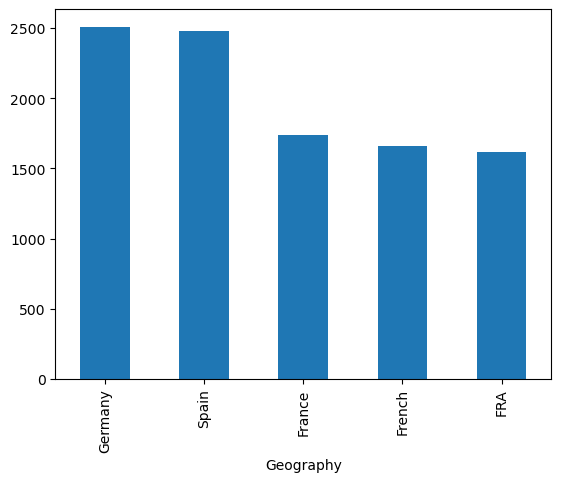

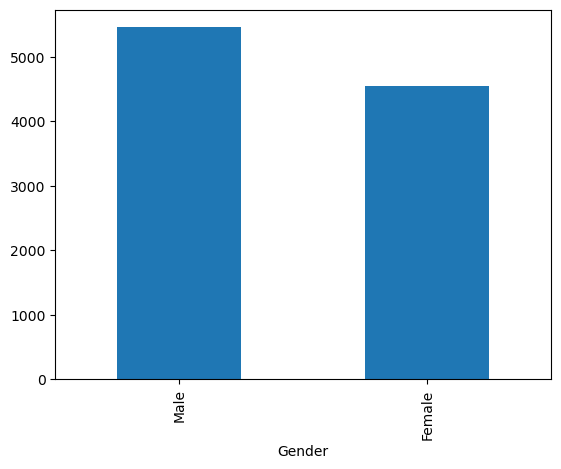

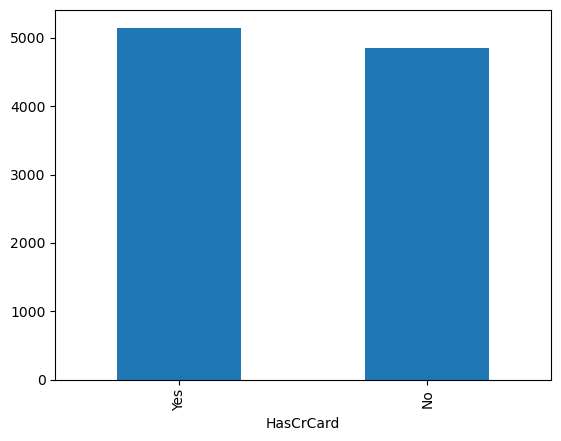

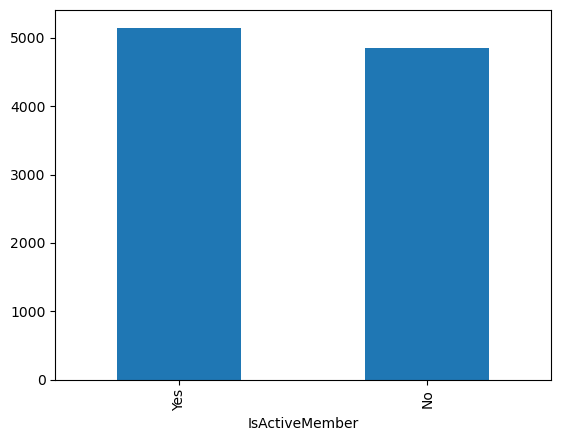

In [12]:
categorical_cols = bank_data.select_dtypes(include='object').columns
for col in categorical_cols:
    bank_data[col].value_counts().plot.bar()
    plt.show()

In [13]:
bank_data['Geography'] = np.where((bank_data['Geography'] == 'FRA') | (bank_data['Geography'] == 'French'), 'France', bank_data['Geography'])

### 4.2 Missing Value Imputation (The KNN Approach)
**Observation:** The `Age` column contained missing values.
**Action:** We utilized **K-Nearest Neighbors (KNN)** imputation.
* **Why KNN?** Unlike mean imputation, KNN preserves the underlying variance and correlations of the data. A missing age is estimated by looking at customers with similar Credit Scores, Balances, and Product Holdings.

In [14]:
bank_data[bank_data.isna().any(axis=1)]

,CreditScore,Geography,Gender,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
29,574,Germany,Female,NaN,3,-999999.0,141349.43,1,Yes,Yes,0
122,674,Spain,Male,NaN,6,-999999.0,120193.42,1,No,No,0
9390,538,France,Female,NaN,2,-999999.0,0.00,1,Yes,Yes,0


In [15]:
numeric_cols =  bank_data.select_dtypes(include=['int','float']).columns

imputer = KNNImputer(n_neighbors=2)
bank_data[numeric_cols] = imputer.fit_transform(bank_data[numeric_cols])


### 4.3 Domain-Based Outlier Validation
We performed a final visual inspection using boxplots to distinguish between *data errors* and *natural outliers*.

* **Findings:**
    * **Age:** Observed upper-bound outliers (e.g., 92 years old).
    * **Credit Score:** Observed lower-bound outliers (e.g., scores near 350).
* **Decision:** **Retained.**
    * **Justification:** These values are factually correct within the banking domain. Standard credit scores (FICO) range from **350 to 850**. A score of 350 represents a high-risk customer, which is exactly the type of signal our churn model needs to detect. Similarly, a 92-year-old active member is a valid edge case.
    * **Impact:** Removing these would bias the model against valid high-risk or elderly demographic segments.

In [16]:
bank_data.describe()

,CreditScore,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,Exited
count,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000,10004.000000
mean,650.568073,38.921281,5.012195,99743.889855,76494.334391,1.529988,0.203719
std,96.665531,10.488876,2.891806,60581.133136,62396.534285,0.581635,0.402782
min,350.000000,18.000000,0.000000,-999999.000000,0.000000,1.000000,0.000000
25%,584.000000,32.000000,3.000000,50904.965000,0.000000,1.000000,0.000000
50%,652.000000,37.000000,5.000000,100168.240000,97221.520000,1.000000,0.000000
75%,718.000000,44.000000,7.000000,149382.097500,127656.530000,2.000000,0.000000
max,850.000000,92.000000,10.000000,199992.480000,250898.090000,4.000000,1.000000


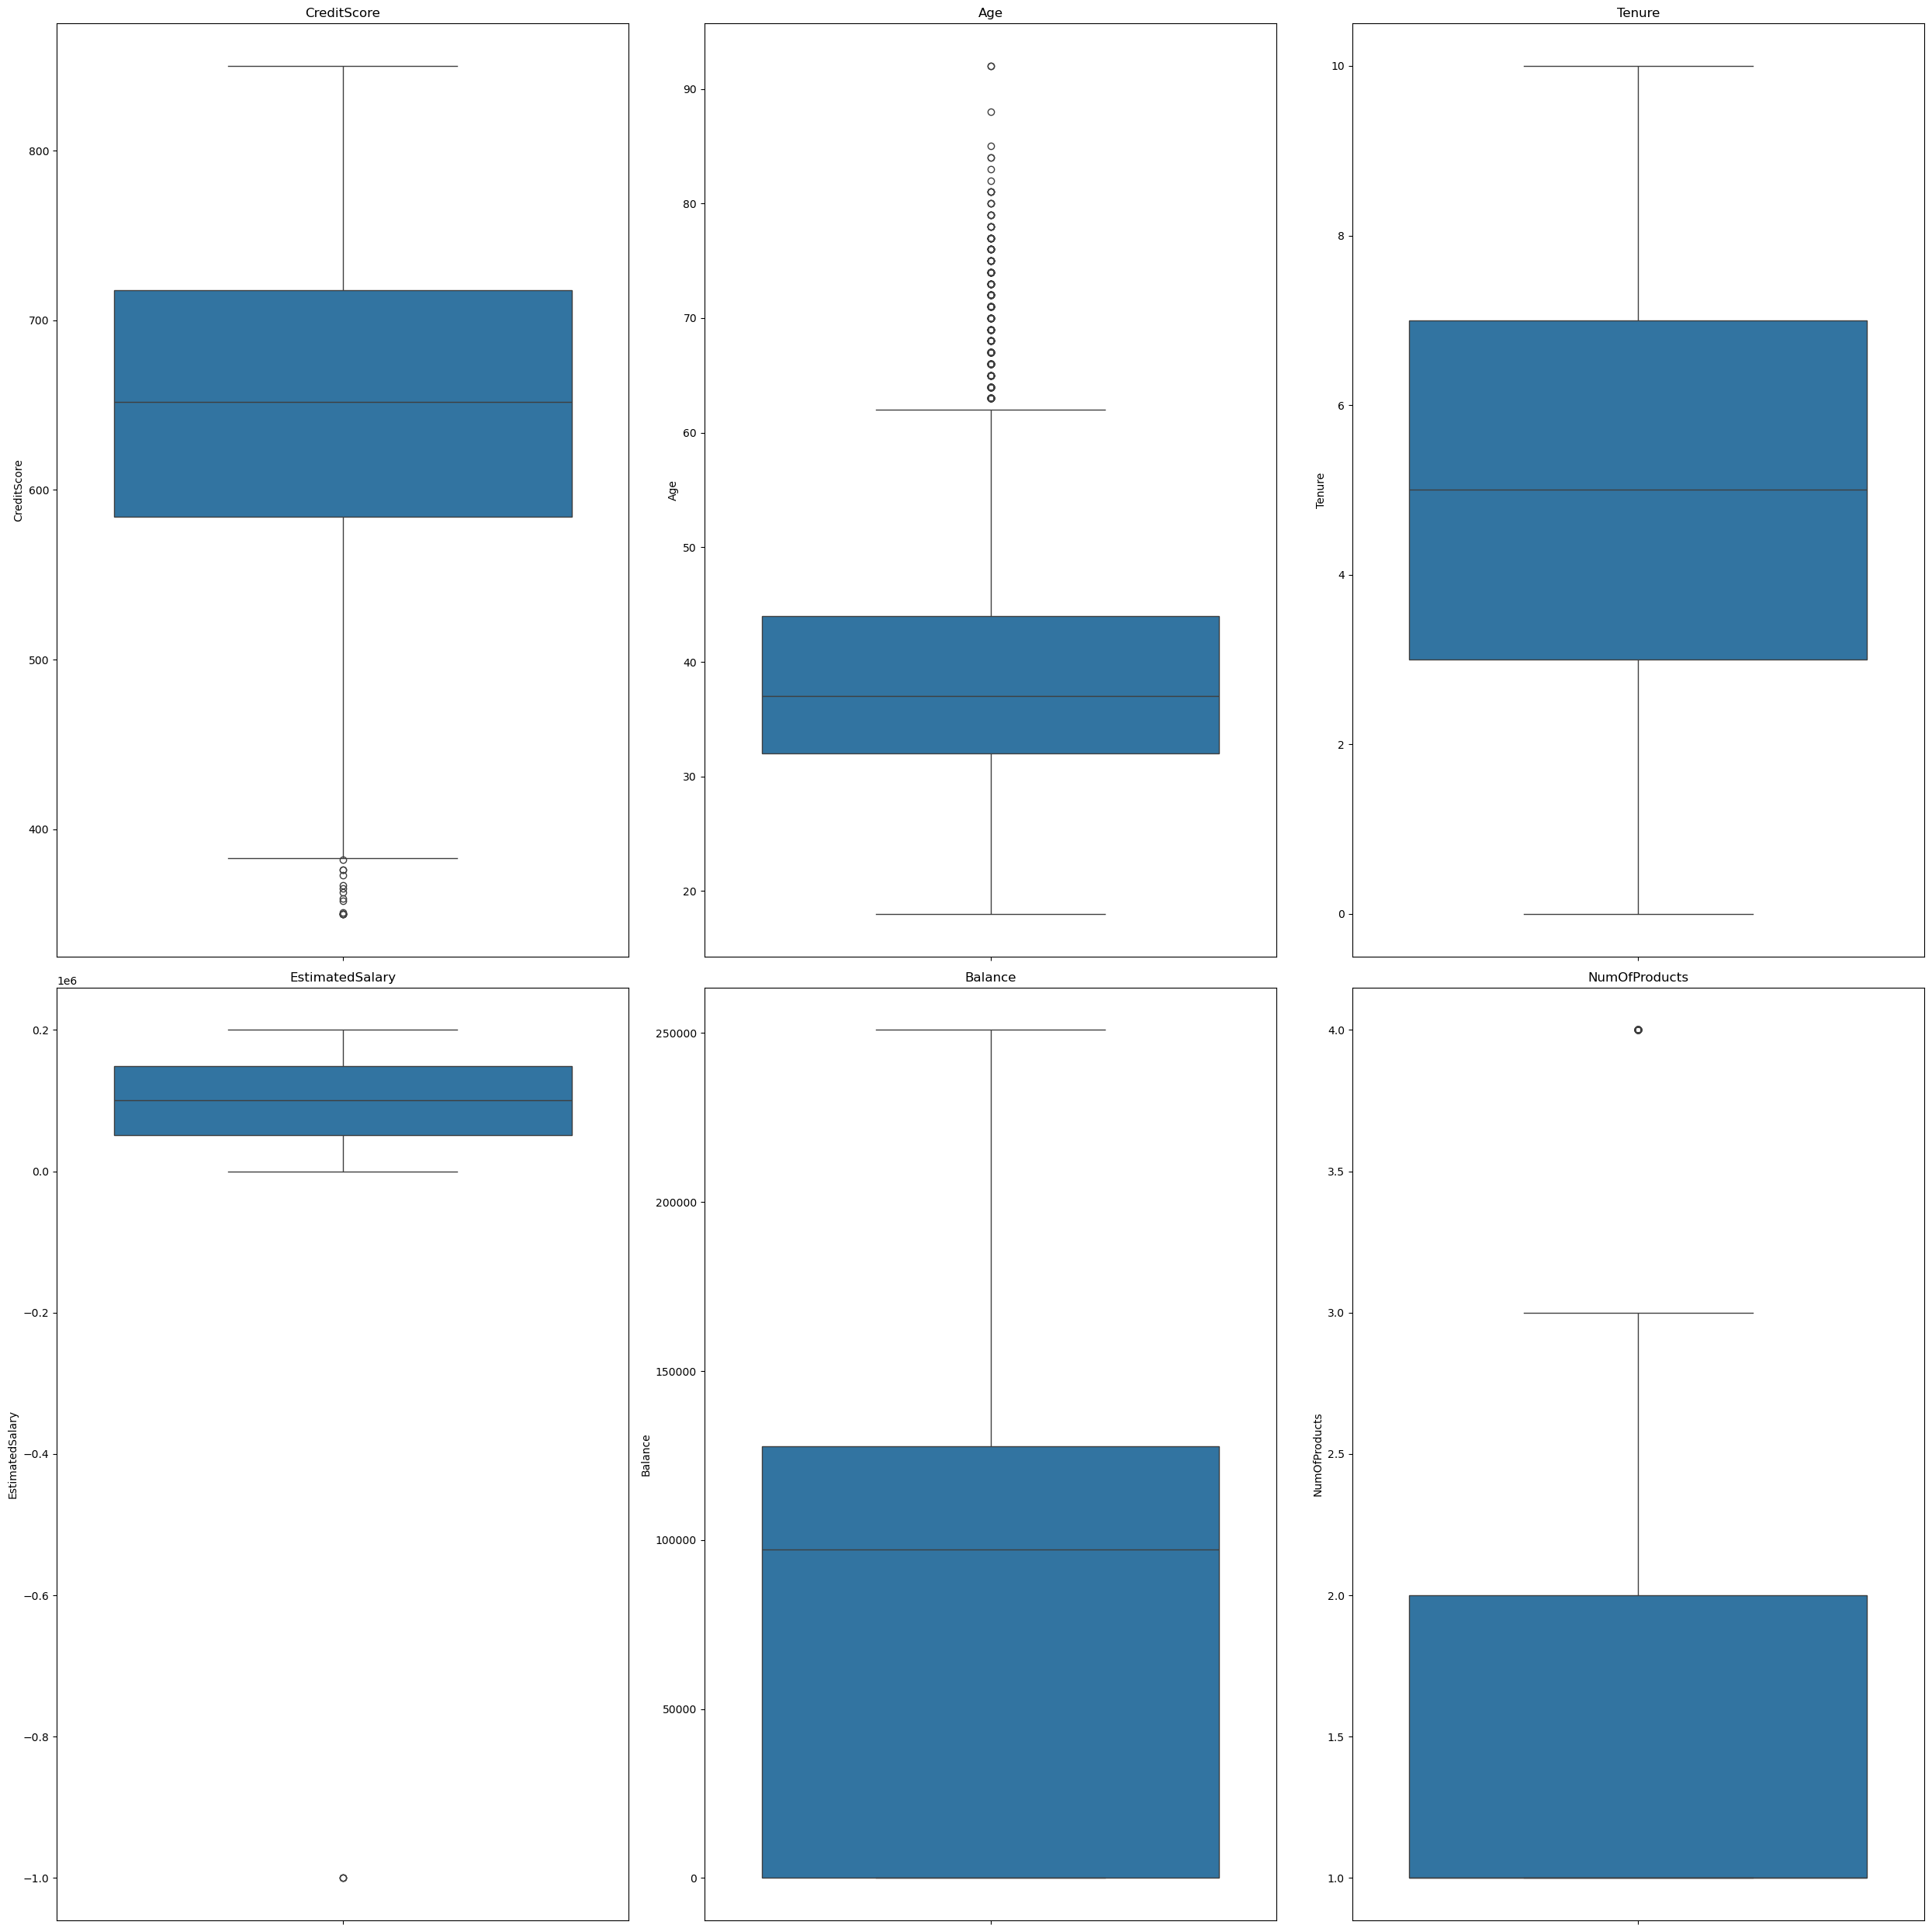

In [17]:
numeric_cols = numeric_cols.drop('Exited')

fig = plt.figure(figsize=(25,25))
for i, col in enumerate(numeric_cols):
    ax = fig.add_subplot(2, 3, i+1)
    sns.boxplot(data = bank_data, y=col, ax = ax)
    plt.title(col)

plt.subplots_adjust(hspace = 0.3, wspace = 0.2)
plt.tight_layout()
plt.show()
    


### 4.4 Anomaly Detection & Handling (EstimatedSalary)
**Issue:** Descriptive statistics and boxplots revealed a critical data error: `EstimatedSalary` contained negative values (min value < 0), which is impossible.

**Strategy:**
Instead of simply taking the absolute value (which assumes a typo) or filling with the mean (which reduces variance), we treated these values as **Missing Data**.
1.  Coerced negative values to `NaN`.
2.  Applied **KNN Imputation** to estimate the salary based on the financial profile of similar neighbors (k=2).

In [18]:
bank_data.loc[bank_data['EstimatedSalary'] < 0, 'EstimatedSalary'] = np.nan

numeric_cols =  bank_data.select_dtypes(include=['int','float']).columns

imputer = KNNImputer(n_neighbors=2)
bank_data[numeric_cols] = imputer.fit_transform(bank_data[numeric_cols])


## 5. Exploratory Data Analysis (EDA) <a id="eda"></a>

### 5.1 Target Variable Distribution
**Observation:** The dataset is significantly **imbalanced**.
* **Retained (0):** ~80% of customers.
* **Churned (1):** ~20% of customers.

**Implication for Modeling:**
A baseline model that predicts "No Churn" for everyone would achieve 80% accuracy but 0% Recall. Since our business goal is to catch churners, **Accuracy is not a valid metric**. We will need to address this imbalance later using techniques like `class_weight='balanced'` or SMOTE (Synthetic Minority Over-sampling).

<Axes: xlabel='Exited'>

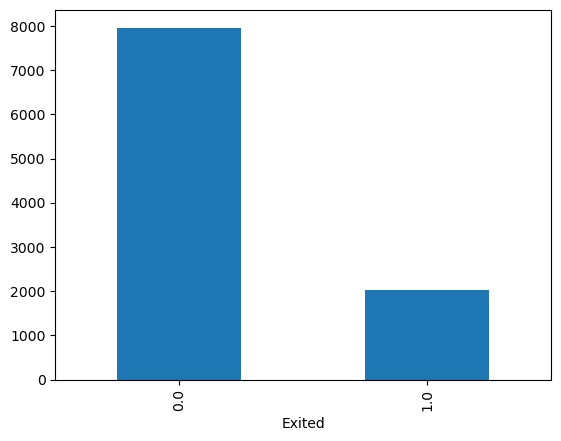

In [19]:
bank_data['Exited'].value_counts().plot.bar()

### 5.2 Multivariate Analysis (Pairplot)
To visualize interactions between multiple features, we plotted a pairwise relationship grid.
* **Sampling Strategy:** Due to the large dataset size, we analyzed a random sample of 1,500 instances to maintain plot readability and rendering speed.
* **Key Insight:** The scatter plots show significant overlap between classes, indicating that there is **no clear linear boundary** separating churners from retained customers. This suggests that linear models (like Logistic Regression) may struggle, and non-linear tree-based models (like Random Forest) will likely perform better.

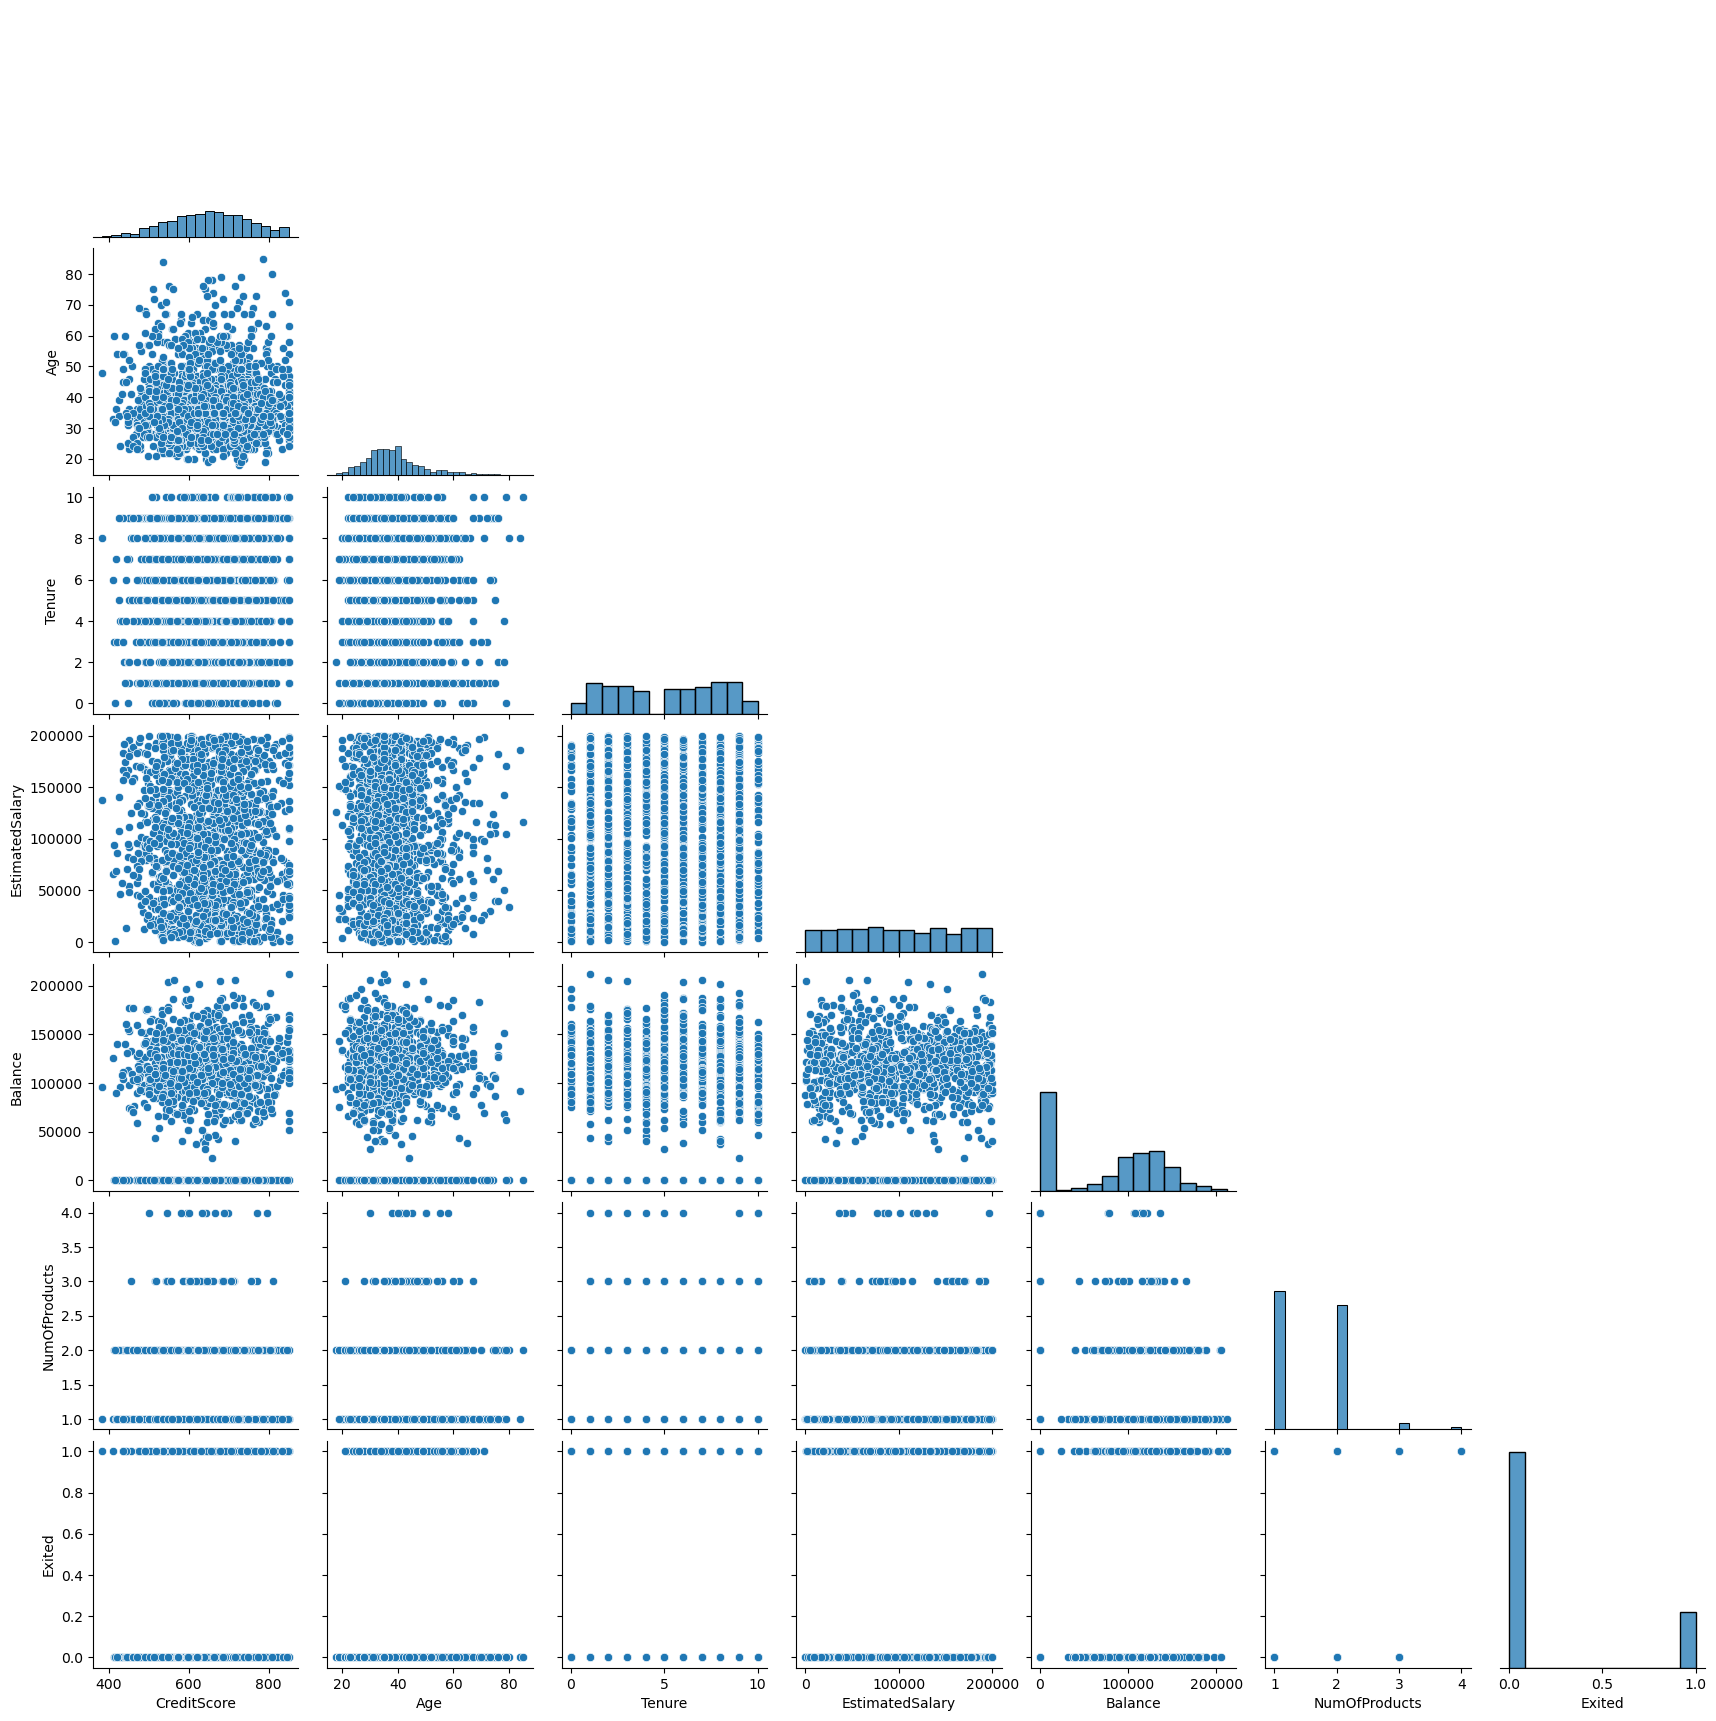

In [20]:
bank_sample = bank_data.sample(n=1500,random_state=123)
sns.pairplot(bank_sample, corner = True)
plt.show()

### 5.3 Feature Distribution & density (KDE Plots)
We inspected the Kernel Density Estimation (KDE) plots to identify which individual features differ most between the two classes.

**Findings:**
1.  **Age:** This is the strongest predictor. The "Churned" (Orange) distribution is shifted to the right, indicating that **older customers (40-60)** are more likely to leave than younger ones.
2.  **Balance:** Churners tend to have higher account balances. This is a critical risk factor, as it implies we are losing **high-value assets**, not just empty accounts.
3.  **NumOfProducts:** The distribution reveals a non-linear relationship. Customers with 2 products are the most stable, while those with 3 or 4 products have a drastically higher churn rate (possibly indicating "over-selling" or confusion).
4.  **EstimatedSalary:** shows a uniform distribution for both classes, suggesting that income level is **not** a primary driver of churn.

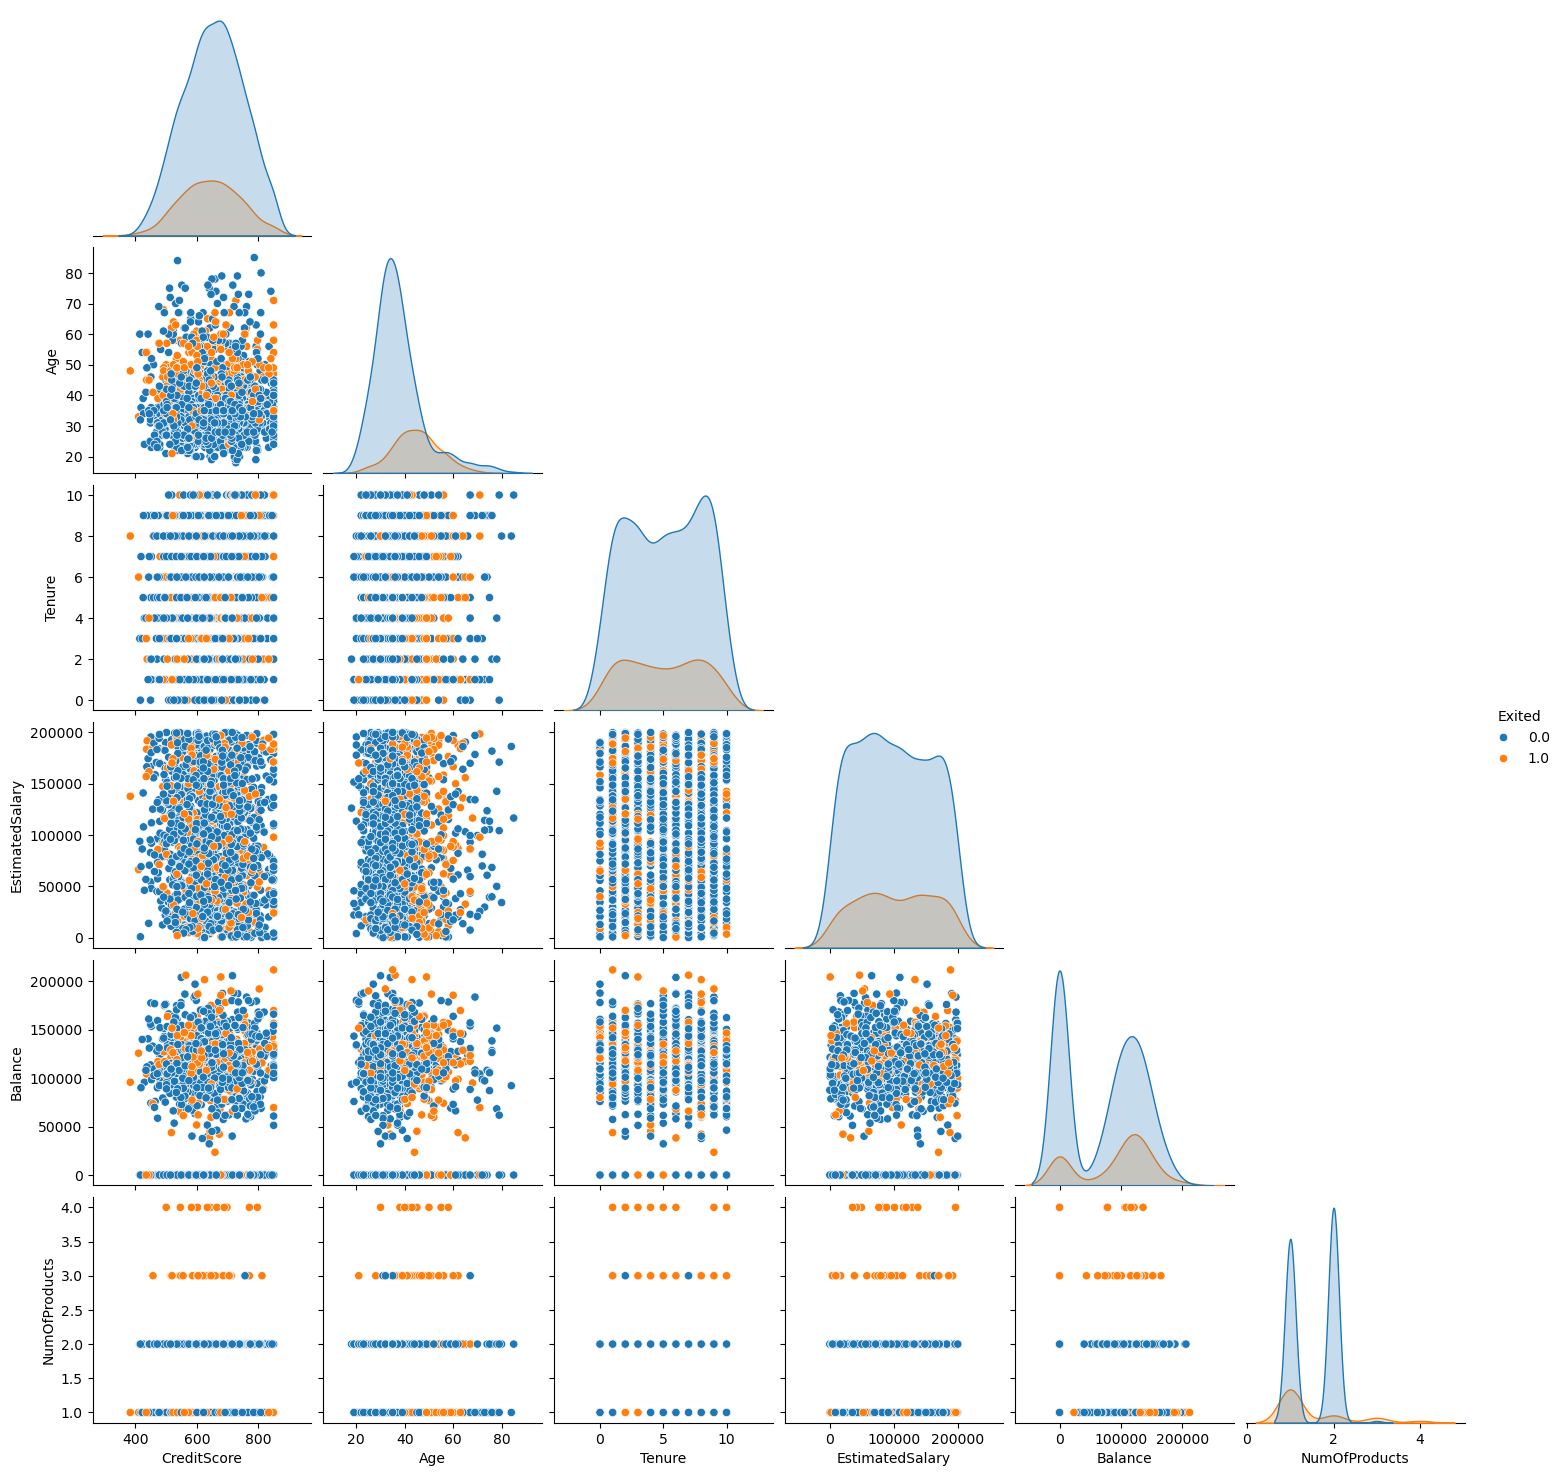

In [21]:
sns.pairplot(bank_sample, corner = True, hue = 'Exited')
plt.show()

Based on this pairplot that is split into two groups by exited we can assume what kind of clients are more likely to churn (For example clients whit large number of products like 4). But besides that, distributions look similar so its hard to tell now by only looking. Because orange nad blue color almost create the same shape and are on them. Ideally it would be separated. 

### 5.4 Correlation Analysis

**Interpretation:**
* **Age vs. Exited (0.29):** Confirms our KDE finding that Age is positively correlated with churn.
* **Balance vs. NumOfProducts (-0.30):** A negative correlation suggests that customers with more products tend to keep lower balances in their primary account (perhaps moving funds to investment products).
* **Multicollinearity:** Aside from the expected relationship between Balance/Products, there are no highly correlated features (> 0.8). This confirms that our feature set is stable and redundant information is minimal.

<Axes: >

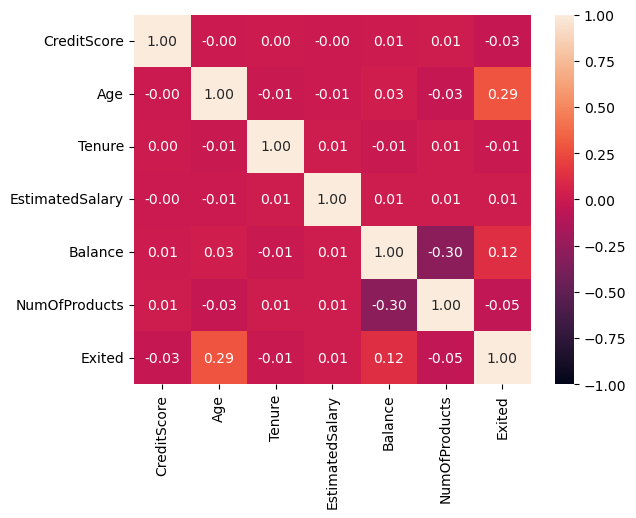

In [22]:
sns.heatmap(bank_data.corr(numeric_only=True), vmin = - 1, vmax =1, annot= True, fmt = '.2f')

Note on Correlation vs. Predictive Power: While NumOfProducts shows low linear correlation with Exited, our Density plots proved it allows for some separation of classes. This highlights the limitation of Pearson correlation for non-linear relationships and reinforces the need for non-linear classifiers.

## 6. Feature Engineering & Data Preparation <a id="feature-engineering"></a>

### 6.1 Feature Creation: Financial Utilization Ratio
**Hypothesis:** A customer's raw balance is less informative than their balance *relative* to their income. A high balance for a low-income earner suggests a different savings behavior than for a high-income earner.

**Action:** We created a derived feature `Balance_to_Salary_Ratio`.
$$Ratio = \frac{Balance}{EstimatedSalary}$$

**Statistical Insight (Mean vs. Median):**
* **Observation:** The *Mean* ratio for churners (9.34) is higher than for retained customers (2.47), but the *Medians* are quite similar (~0.70 vs ~0.88).
* **Conclusion:** The discrepancy between Mean and Median indicates a **highly right-skewed distribution** with significant outliers in the "Churned" group. These customers (high balance, low reported salary) are a specific segment at high risk of leaving.

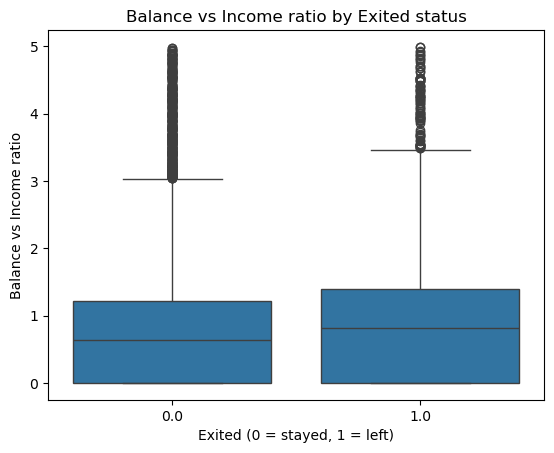

In [23]:
bank_data['balance_vs_income'] = bank_data['Balance'] / bank_data['EstimatedSalary']
filtered = bank_data[bank_data['balance_vs_income'] < 5]
sns.boxplot(x='Exited', y='balance_vs_income', data=filtered)
plt.title('Balance vs Income ratio by Exited status')
plt.xlabel('Exited (0 = stayed, 1 = left)')
plt.ylabel('Balance vs Income ratio')
plt.show()

In [24]:
print(f"Mean of Balance vs Income based on Exited group:\n{bank_data.groupby('Exited')['balance_vs_income'].mean()}\n"
      f"Median of Balance vs Income based on Exited group:\n{bank_data.groupby('Exited')['balance_vs_income'].median()}")

Mean of Balance vs Income based on Exited group:
Exited
0.0    2.478910
1.0    9.348387
Name: balance_vs_income, dtype: float64
Median of Balance vs Income based on Exited group:
Exited
0.0    0.703707
1.0    0.886936
Name: balance_vs_income, dtype: float64


### 6.2 Categorical Encoding
Machine learning algorithms require numerical input. We applied **One-Hot Encoding** to categorical variables (`Geography`, `Gender`, etc.).

* **Strategy:** We used `drop_first=True` to remove the first category of each feature.
* **Reasoning:** This prevents the **Dummy Variable Trap** (perfect multicollinearity), where one variable can be predicted perfectly from the others (e.g., if `Is_Male` is 0, `Is_Female` must be 1).

In [25]:
bank_data_dummies = pd.get_dummies(bank_data, drop_first= True, dtype='int')
bank_data_dummies.head()

,CreditScore,Age,Tenure,EstimatedSalary,Balance,NumOfProducts,Exited,balance_vs_income,Geography_Germany,Geography_Spain,Gender_Male,HasCrCard_Yes,IsActiveMember_Yes
0,619.0,42.0,2.0,101348.88,0.00,1.0,1.0,0.000000,0,0,0,1,1
1,619.0,42.0,2.0,101348.88,0.00,1.0,1.0,0.000000,0,0,0,1,1
2,608.0,41.0,1.0,112542.58,83807.86,1.0,0.0,0.744677,0,1,0,1,1
3,502.0,42.0,8.0,113931.57,159660.80,3.0,1.0,1.401375,0,0,0,0,0
4,699.0,39.0,1.0,93826.63,0.00,2.0,0.0,0.000000,0,0,0,0,0


### 6.3 Train-Test Split
To simulate real-world performance and prevent overfitting, we split the data:
* **Training Set (80%):** Used to learn patterns.
* **Test Set (20%):** Used as an unseen validation set.

In [26]:
X = bank_data_dummies.drop(columns=['Exited'])
y = bank_data_dummies['Exited']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 123)

### 6.4 Feature Scaling
**Algorithm Requirement:** Logistic Regression relies on distance calculations and gradient descent. Features with large magnitudes (like `Balance` ~100k) would dominate features with small magnitudes (like `Age` ~40).

**Action:** We applied `StandardScaler` to normalize features to a mean of 0 and standard deviation of 1.
* **Crucial Step:** The scaler was **fit only on the Training set** and then applied to the Test set. This prevents **Data Leakage**, ensuring the model has no knowledge of the test data distribution during training.

In [27]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

## 7. Model Training: Logistic Regression <a id="logistic-regression"></a>

### 7.1 Baseline Model (The "Accuracy Paradox")
We began by training a standard Logistic Regression model with default hyperparameters.

**Result Analysis:**
* **Accuracy:** 79% (Seemingly high).
* **Recall (Churners):** **4%** (Catastrophic).

**Diagnosis:** The model is biased toward the majority class (Retained). It achieves "high accuracy" simply by predicting that *no one* will churn. This renders the model useless for our business objective.

In [28]:
lr = LogisticRegression()
lr_model = lr.fit(X_train, y_train)
print(classification_report(y_test, lr_model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.80      0.97      0.88      1600
         1.0       0.29      0.04      0.07       401

    accuracy                           0.79      2001
   macro avg       0.55      0.51      0.48      2001
weighted avg       0.70      0.79      0.72      2001



### 7.2 Strategic Hyperparameter Tuning
To address the significant Recall deficiency in the baseline model (4%), we shifted from default settings to a targeted tuning strategy. We employed `RandomizedSearchCV` for a broad initial sweep, followed by `GridSearchCV` for fine-tuning, with **Recall** as the optimization metric.

**Key Configuration Choices:**

1.  **Addressing Imbalance (`class_weight='balanced'`):**
    * Standard Logistic Regression treats all errors equally. Given our 80:20 imbalance, the model ignored churners to maximize total accuracy.
    * **The Fix:** Setting this parameter automatically adjusts weights inversely proportional to class frequencies. The model is now heavily penalized for failing to identify the minority class (Churners).

2.  **Solver Selection (`solver='saga'`):**
    * We selected the Stochastic Average Gradient Descent (`saga`) solver because it is the only algorithm in Scikit-Learn that supports all penalty types (L1, L2, and ElasticNet). It is also highly efficient for datasets with large feature sets.

3.  **Regularization Strategy (ElasticNet):**
    * **The Approach:** We utilized the **ElasticNet** penalty, which allows the model to learn the optimal mix of L1 and L2 regularization via the `l1_ratio` parameter.
    * **L1 (Lasso):** Enforces sparsity by driving coefficients of non-predictive features to exactly zero (Automatic Feature Selection).
    * **L2 (Ridge):** Penalizes large coefficients without removing them entirely. This is crucial for handling **multicollinearity** (e.g., the relationship between `Balance` and `NumOfProducts`) and stabilizing the model against noise.
    * **C (Inverse Regularization Strength):** We tuned this parameter to find the "sweet spot" between underfitting (high bias) and overfitting (high variance).

In [ ]:
parameters = [
    # Config 1: L1 or L2 penalty 
    {
        'penalty': ['l1', 'l2'],
        'C': np.linspace(0.1, 2, 20),
        'class_weight': ['balanced', None],
        'solver': ['saga']
    },
    # Config 2: Elasticnet 
    {
        'penalty': ['elasticnet'],
        'C': np.linspace(0.1, 2, 20),
        'l1_ratio': np.linspace(0, 1, 11),
        'class_weight': ['balanced', None],
        'solver': ['saga']
    }
]



recall_scorer = make_scorer(recall_score, pos_label = 1)

random_search = RandomizedSearchCV(
    LogisticRegression(solver='saga', max_iter=500),
    parameters,
    n_iter=50,   
    cv=5,        
    random_state=42, 
    scoring= recall_scorer
)
random_search.fit(X_train_std, y_train)
print(random_search.best_params_)

{'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 1.0, 'class_weight': 'balanced', 'C': 0.7}


In [30]:
parameters2 = {
    'penalty': ['elasticnet'],
    'class_weight': ['balanced'],
    'C': np.linspace(0.6, 0.8, 20),
    'l1_ratio': np.linspace(0.8, 1.0, 20)
}

gridsearch = GridSearchCV(LogisticRegression(solver='saga', max_iter=500), parameters2, scoring = recall_scorer)
gridsearch.fit(X_train_std, y_train)
print("Best Parameters found by Fine-Tuning:")
print(gridsearch.best_params_)

KeyboardInterrupt: 

### 7.3 Final Model Evaluation
**Best Parameters:** `C=0.6`, `penalty='elasticnet'`, `l1_ratio=0.8`, `class_weight='balanced'`.

**Performance Shift:**
* **Recall (Churners):** Increased from **4% $\rightarrow$ 70%**.
* **Trade-off:** Precision decreased to ~39%.

**Business Interpretation:**
While we now have more False Positives (prediction: churn, reality: stay), this is acceptable. It is far better to send a discount email to a happy customer (False Positive) than to let an unhappy customer leave unnoticed (False Negative).

In [ ]:
lr_model_tuned = gridsearch.best_estimator_
print(classification_report(y_test, lr_model_tuned.predict(X_test_std)))

              precision    recall  f1-score   support

         0.0       0.91      0.73      0.81      1600
         1.0       0.39      0.70      0.50       401

    accuracy                           0.72      2001
   macro avg       0.65      0.71      0.66      2001
weighted avg       0.80      0.72      0.75      2001



### 7.4 The Cost-Benefit Analysis (Confusion Matrix)
The Confusion Matrix allows us to quantify the business impact of our "Recall-First" strategy:

* **True Positives (279):** We successfully identified ~70% of the customers who were about to leave. These are 279 opportunities to intervene and save revenue.
* **False Negatives (122):** We missed these customers. While not ideal, this is significantly lower than the baseline model (which missed almost everyone).
* **False Positives (432):** We predicted these customers would leave, but they stayed.
    * *Trade-off:* We might send a discount code to these 432 people. While this costs margin, it is a justifiable expense compared to the high cost of losing a client (CAC vs. Retention Cost).



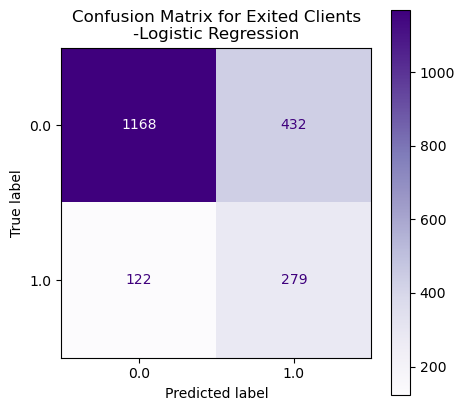

In [ ]:
cm_lr = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, lr_model_tuned.predict(X_test_std)), display_labels= lr_model_tuned.classes_)

fig, ax = plt.subplots(figsize=(5, 5))
cm_lr.plot(cmap='Purples', ax=ax)
ax.set_title('Confusion Matrix for Exited Clients\n-Logistic Regression')
plt.show()

### 7.5 Feature Importance: Drivers of Churn
Unlike complex "black-box" models, Logistic Regression provides **directional interpretability** through its coefficients.

**Risk Factors (Positive Coefficients $\uparrow$ Churn):**
1.  **Age (+0.80):** The dominant driver. Older customers are far more likely to exit. This suggests our product suite may be optimized for younger demographics (e.g., digital-only features) and alienating older clients.
2.  **Geography: Germany (+0.33):** Being a German customer increases the log-odds of churn, hinting at a regional competitor or dissatisfaction with local service levels.
3.  **Balance (+0.16):** High-balance customers are surprisingly riskier, confirming our EDA finding that we are bleeding high-value assets.

**Protective Factors (Negative Coefficients $\downarrow$ Churn):**
1.  **Gender: Male (-0.27):** Male customers are statistically more stable than female customers.
2.  **IsActiveMember (-0.22):** Engagement works. Customers who actively use banking services are significantly less likely to leave.

In [ ]:
lr_model_tuned_coef = pd.DataFrame({'feature' : X_train.columns,
             'coef' : lr_model_tuned.coef_[0],
             'abs_coef' : np.abs(lr_model_tuned.coef_[0])}).sort_values(by='abs_coef', ascending = False)
lr_model_tuned_coef


,feature,coef,abs_coef
1,Age,0.801380,0.801380
7,Geography_Germany,0.334055,0.334055
9,Gender_Male,-0.268551,0.268551
10,HasCrCard_Yes,-0.217936,0.217936
11,IsActiveMember_Yes,-0.217936,0.217936
4,Balance,0.162078,0.162078
0,CreditScore,-0.078178,0.078178
5,NumOfProducts,-0.059735,0.059735
8,Geography_Spain,0.049341,0.049341
2,Tenure,-0.044896,0.044896


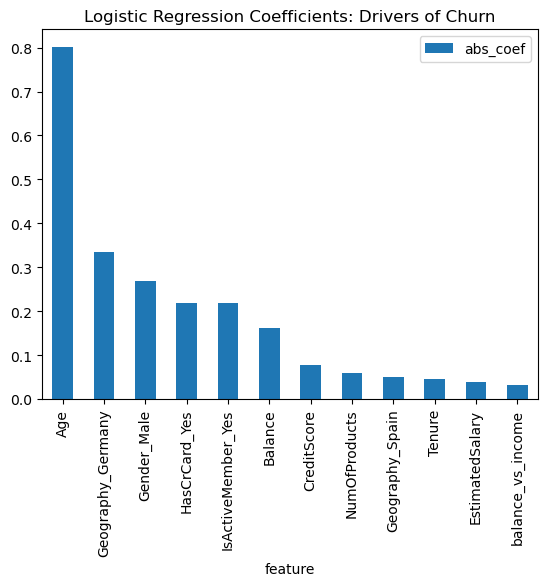

In [ ]:
lr_model_tuned_coef.plot(kind='bar', x='feature', y ='abs_coef', title='Logistic Regression Coefficients: Drivers of Churn')
plt.show()

## 8. Final Model: Random Forest Classifier <a id="random-forest"></a>

### 8.1 Moving from Linear to Non-Linear
While our Logistic Regression model improved significantly with tuning (Recall ~70%), it plateaued due to the "Linearity Ceiling." It could not capture complex interactions, such as the specific risk profile of older customers with multiple products.

To address this, we advanced to a **Random Forest Classifier**, an ensemble method that aggregates hundreds of decision trees to model non-linear boundaries.

### 8.2 Baseline Performance (The "Imbalance Trap")
We first trained a Random Forest with default hyperparameters to establish a baseline.

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,             
    class_weight='balanced',       
    random_state=123,              
    n_jobs=-1                      
)

rf_model.fit(X_train, y_train)

print("Classification Report for Random Forest Model:")
print(classification_report(y_test, rf_model.predict(X_test)))

Classification Report for Random Forest Model:
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92      1600
         1.0       0.81      0.45      0.58       401

    accuracy                           0.87      2001
   macro avg       0.84      0.71      0.75      2001
weighted avg       0.86      0.87      0.85      2001



**Baseline Observation:**
* **Accuracy:** 86% (High)
* **Recall:** 45% (Unacceptably Low)

**Diagnosis:** The default Random Forest is biased toward the majority class (Retained). It maximizes accuracy by ignoring the minority churners. This confirms that **Hyperparameter Tuning**, specifically class weighting, is mandatory.

### 8.3 Hyperparameter Optimization
We employed a two-stage tuning strategy (`RandomizedSearchCV` $\rightarrow$ `GridSearchCV`) to optimize the forest for **Recall**.

**Key Configuration:**
1.  **`class_weight='balanced'`:** This is the most critical parameter. It forces the trees to penalize false negatives heavily, correcting the bias we saw in the baseline.
2.  **`max_depth` (7-9):** We constrained the depth to prevent the trees from memorizing the noise in the training data (overfitting).
3.  **`min_samples_leaf`:** Increasing this ensures that every "decision" made by a leaf node is based on a statistically significant number of samples.

In [ ]:
params_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [8, 13, 18, 25, None], 
    'min_samples_leaf': [5, 10, 15, 20],
    'max_features': [0.5, 0.7, 'sqrt', 'log2'],
    'class_weight': ['balanced'], 
}

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=123), 
    param_distributions=params_rf,                      
    scoring=recall_scorer,                                   
    n_iter=25,         
    cv=5,               
    random_state=123,
    n_jobs=-1
)

random_search_rf.fit(X_train,y_train)

random_search_rf.best_params_

{'n_estimators': 150,
 'min_samples_leaf': 15,
 'max_features': 0.7,
 'max_depth': 8,
 'class_weight': 'balanced'}

In [ ]:
params_rf = {'n_estimators': [150],
 'min_samples_leaf': [14,15,16],
 'max_features': np.linspace(0.60, 0.80, 10),
 'max_depth': [7,8,9],
 'class_weight': ['balanced']}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=123), 
    param_grid=params_rf, 
    scoring= recall_scorer,         
    cv=5,
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train) 
print(grid_search_rf.best_params_)


{'class_weight': 'balanced', 'max_depth': 7, 'max_features': 0.7555555555555555, 'min_samples_leaf': 14, 'n_estimators': 150}


In [ ]:
rf_model_tuned = grid_search_rf.best_estimator_

print("Classification Report for Random Forest Tuned Model:")
print(classification_report(y_test, rf_model_tuned.predict(X_test)))

Classification Report for Random Forest Tuned Model:
              precision    recall  f1-score   support

         0.0       0.93      0.84      0.88      1600
         1.0       0.54      0.76      0.63       401

    accuracy                           0.82      2001
   macro avg       0.74      0.80      0.76      2001
weighted avg       0.85      0.82      0.83      2001



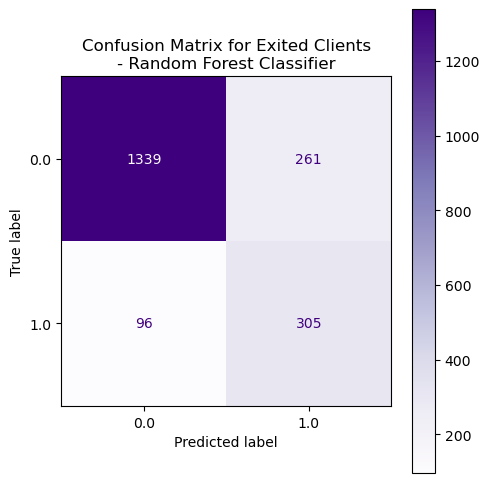

In [ ]:
cm_rf = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, rf_model_tuned.predict(X_test)), display_labels= rf_model_tuned.classes_)

fig, ax = plt.subplots(figsize=(5, 5))
cm_rf.plot(cmap='Purples', ax=ax)
ax.set_title('Confusion Matrix for Exited Clients\n- Random Forest Classifier')
plt.tight_layout()
plt.show()

### 8.4 Final Evaluation: The Final Model
After tuning, the Random Forest performance improved dramatically, validating our strategy.

**Performance Jump:**
* **Baseline Recall:** 45% $\rightarrow$ **Tuned Recall: 76%**
* **Comparison:** This outperforms the tuned Logistic Regression (70%) by a solid margin (+6%), proving that non-linear interactions play a significant role in customer churn.

**Confusion Matrix Analysis:**
* **True Positives (305):** We are now correctly identifying 76% of all at-risk customers.
* **False Positives (261):** Interestingly, the Random Forest has fewer False Positives than Logistic Regression (which had ~430). This means the Random Forest is not just more sensitive, it is **more precise**.

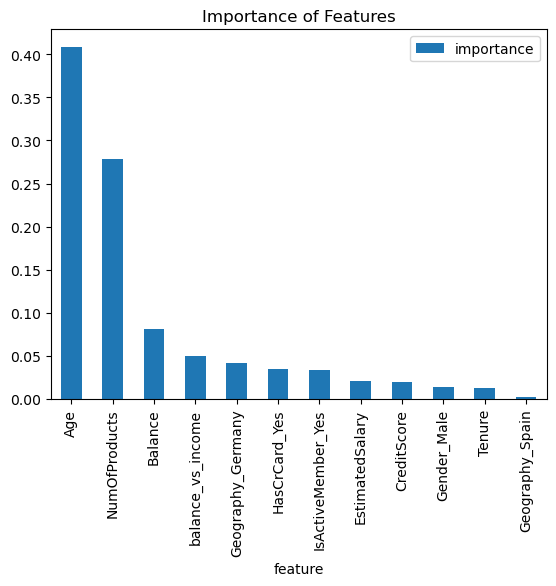

In [ ]:
rf_model_tuned_importance = pd.DataFrame({'feature' : X_train.columns,
             'importance' : rf_model_tuned.feature_importances_}).sort_values(by='importance', ascending= False)
rf_model_tuned_importance.plot(kind='bar', x='feature', title='Importance of Features')
plt.show()

## 9. Model Explainability (SHAP Values) <a id="shap-analysis"></a>
One common criticism of Random Forest is that it is a "Black Box." To provide actionable business insights, we used **SHAP (SHapley Additive exPlanations)**. This Game Theoretic approach explains the marginal contribution of each feature to the final prediction.

In [ ]:
explainer = shap.TreeExplainer(rf_model_tuned)
shap_values = explainer(X_test.sample(80, random_state = 123))
shap_values_class_1 = shap_values[:, :, 1]
shap_df = pd.DataFrame(shap_values_class_1.values, columns = X_test.columns)

### 9.1 Feature Importance (Beeswarm Plot)
The Beeswarm plot reveals the direction and magnitude of impact:

1.  **Age (High Impact):**
    * **Red dots (Older) $\rightarrow$ Right side (Positive SHAP/Churn):** Older customers are the highest risk group.
    * **Blue dots (Younger) $\rightarrow$ Left side (Negative SHAP/Stay):** Younger customers are safe.
2.  **NumOfProducts:**
    * **Red dots (High count) $\rightarrow$ Right side:** Having 3 or 4 products is a massive churn signal (likely due to poor product bundling or fees).
    * **Blue dots (Low count) $\rightarrow$ Left side:** Customers with 1-2 products are stable.
3.  **Geography_Germany:**
    * Being in Germany (Red) is a strong predictor of churn compared to France/Spain.
4.  **IsActiveMember:**
    * **Red (Yes):** Active members are on the left (Safe).
    * **Blue (No):** Inactive members are on the right (Risk). **Action Item:** We must engage inactive users *before* they churn.

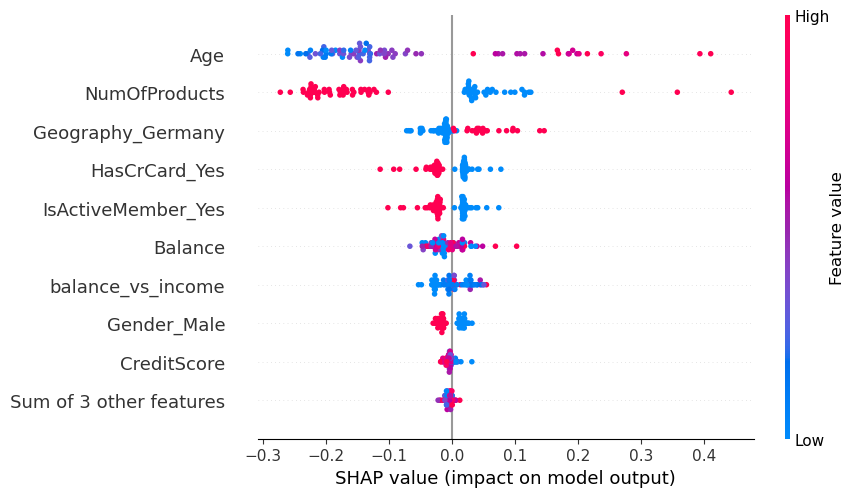

In [ ]:
shap.plots.beeswarm(shap_values_class_1)

### 9.2 Interaction Effects (Age vs. Num of Products)
The scatter plot highlights a critical interaction:
* **The Danger Zone:** The risk skyrockets for customers **over age 40** who hold **3+ products**. This specific segment is where the bank is bleeding the most value.

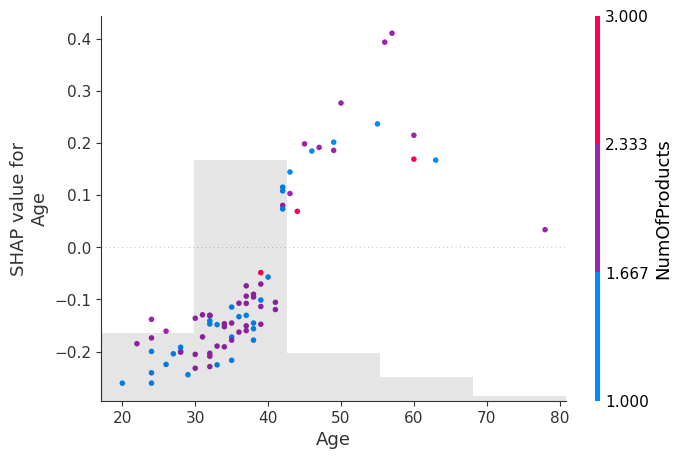

In [ ]:
shap.plots.scatter(
    shap_values_class_1[:, 1],   
    color=shap_values_class_1[:, 5] 
)

### 9.3 Local Interpretability: High-Risk Case Study
The Waterfall plot illustrates the decision path for a specific customer flagged with an **83.3% probability of churn**.

**Profile Analysis:**
* **Primary Risk Driver (Age = 57):** The customer's age is the dominant factor, increasing the churn probability by **+41%**. This confirms our global finding that the 50-60 age bracket is highly unstable.
* **Secondary Risks (Inactivity):** The feature `IsActiveMember_Yes = 0` (meaning the customer is **Inactive**) further increases risk by **+7%**.
* **Protective Factors (Products = 2):** Interestingly, this customer holds 2 products, which indicates stability (lowering risk by **-17%**).

**Actionable Insight:**
We cannot change the customer's age, but we can address their engagement.
* **Recommendation:** Since `IsActiveMember` is a controllable variable, a targeted phone call offering a "Loyalty Check-up" could flip their status to Active, potentially lowering their total risk score below the churn threshold.

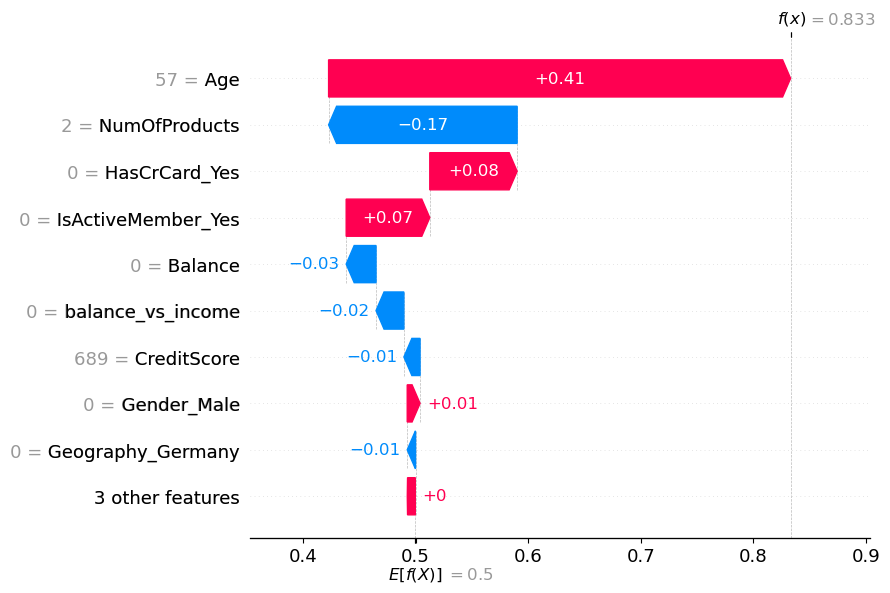

In [ ]:
high_risk_indices = np.where(rf_model_tuned.predict_proba(X_test)[:, 1] > 0.8)[0]

example_idx = high_risk_indices[0]

shap.plots.waterfall(shap_values_class_1[example_idx])

## 10. Model Deployment: Risk Scoring Simulation <a id="deployment"></a>
A machine learning model provides value only when it translates into business decisions. In this final step, we simulate a production environment where the model scores new, unseen customers.

### 10.1 The Scoring Logic
Instead of a simple binary prediction (Churn/No Churn), we implemented a **Risk Segmentation System** based on probability thresholds. This allows the bank to prioritize resources:

* **Low Risk (0 - 50%):** Happy customers. **Action:** No intervention needed.
* **Medium Risk (50 - 75%):** Warning signs detected. **Action:** Send automated retention emails or app notifications.
* **High Risk (75 - 100%):** Immediate danger of churn. **Action:** Assign to a relationship manager for a direct phone call.

### 10.2 Operational Simulation: Batch vs. Real-Time
To demonstrate the model's versatility in a production environment, we executed two distinct deployment scenarios:

1.  **Scenario A: Batch Scoring (Portfolio Audit):**
    * **Goal:** To quantify risk within the existing customer base.
    * **Method:** We applied the model to the **Test Set** to mimic a periodic system scan. This generates a prioritized "Call List" of current clients who need immediate intervention.

2.  **Scenario B: Real-Time Scoring (New Leads):**
    * **Goal:** To assess new customers instantly upon onboarding.
    * **Method:** We generated **Synthetic Customer Profiles** to simulate a live API response. This shows how the model assigns risk segments (Low/Medium/High) in real-time to trigger automated workflows.

In [ ]:
df_exited_risk = pd.DataFrame(columns=['CustomerID','Exited_Prob','Risk_Segment'])

In [ ]:
customers = X_test
y_prob_customers = np.round(rf_model_tuned.predict_proba(customers)[:,1],2)

df_old_customers = pd.DataFrame({'CustomerID' : bank_data_full.loc[X_test.index, 'CustomerId'], 'Exited_Prob' : y_prob_customers})
df_exited_risk = pd.concat([df_exited_risk,df_old_customers], ignore_index= True)
df_exited_risk['Risk_Segment'] = pd.cut(
    df_exited_risk['Exited_Prob'],
    bins=[0, 0.5, 0.75, 1],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)


C:\Users\karol\AppData\Local\Temp\ipykernel_3532\1454392239.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_exited_risk = pd.concat([df_exited_risk,df_old_customers], ignore_index= True)


In [ ]:
def generate_unique_ids(existing_ids, n, id_min=10000, id_max=99999):
    unique_ids = set(existing_ids) 
    new_ids = []
    
    while len(new_ids) < n:
        candidate = np.random.randint(id_min, id_max+1)
        if candidate not in unique_ids:
            new_ids.append(candidate)
            unique_ids.add(candidate)
    
    return new_ids

In [ ]:
new_customer = pd.DataFrame({
    'CreditScore': [250,400],
    'Age': [70,30],
    'Tenure': [4,1],
    'EstimatedSalary': [60000,40000],
    'Balance': [10000,0],
    'NumOfProducts': [3,2],
    'balance_vs_income' : [0, 1.4],
    'Geography_Germany': [1,1],
    'Geography_Spain': [0,0],
    'Gender_Male': [1,0],
    'HasCrCard_Yes': [0,1],
    'IsActiveMember_Yes': [0,0]
})


In [ ]:
y_prob_new_customer = np.round(rf_model_tuned.predict_proba(new_customer)[:,1],2)

num_new_customers = len(new_customer)
new_ids = generate_unique_ids(df_exited_risk['CustomerID'], num_new_customers)

df_new_customer = pd.DataFrame({
    'CustomerID': new_ids,
    'Exited_Prob': y_prob_new_customer
})

df_new_customer['Risk_Segment'] = pd.cut(
    df_new_customer['Exited_Prob'],
    bins=[0, 0.50, 0.7, 1],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

df_exited_risk = pd.concat([df_exited_risk, df_new_customer], ignore_index=True)

print(df_exited_risk[-2:])

     CustomerID  Exited_Prob Risk_Segment
2001      85111         0.91    High Risk
2002      91034         0.17     Low Risk


In [ ]:
print("--- HIGH RISK CUSTOMERS LIST ---")
display(df_exited_risk[df_exited_risk['Risk_Segment'] == 'High Risk'].sort_values(by='Exited_Prob', ascending= False).head(5))

print("\n--- PORTFOLIO RISK DISTRIBUTION ---")
print(df_exited_risk['Risk_Segment'].value_counts().sort_index())

--- HIGH RISK CUSTOMERS LIST ---


,CustomerID,Exited_Prob,Risk_Segment
1927,15791780,0.99,High Risk
226,15640846,0.99,High Risk
780,15582129,0.98,High Risk
1751,15752342,0.98,High Risk
285,15677310,0.98,High Risk



--- PORTFOLIO RISK DISTRIBUTION ---
Risk_Segment
Low Risk       1441
Medium Risk     320
High Risk       242
Name: count, dtype: int64


# 11. Conclusion & Business Recommendations <a id="conclusion"></a>

### Project Summary
We successfully built a churn prediction model that improved to 76% Recall. This translates to identifying 3 out of every 4 customers at risk of leaving.

### Strategic Actions
Based on the SHAP insights, we recommend the following targeted interventions:
1.  **The Senior Retention Program:** Customers over 45 require immediate attention. We should review our product usability and service fees for this demographic.
2.  **Germany Investigation:** The high churn rate in Germany suggests a structural issue (competitor offers or poor local service). A regional audit is recommended.
3.  **Product Bundle Review:** Customers with 3+ products are leaving. We should investigate if "over-bundling" is leading to higher fees or complexity that frustrates clients.
4.  **Re-Engagement Campaign:** Inactive members are high risk. An automated email drip campaign to re-engage dormant accounts could significantly reduce churn.